In [1]:
import numpy as np

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib.signal import s, z, nrmse, LinearSystem

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

import time

import sys

from brian2 import *

In [2]:
BrianLogger.suppress_name('resolution_conflict')

class DurstewitzBrian(NeuronType):
    
    probeable = ('spikes', 'voltage')

    def __init__(self, v0=-65.0*mV, dt_brian=0.025*ms, ode='rk4',
            gain=None, bias=None, max_rates=None, intercepts=None):
        super(DurstewitzBrian, self).__init__()
        self.v0 = v0
        self.dt_brian = dt_brian
        self.ode = ode
        self.gain = gain
        self.bias = bias
        self.max_rates = max_rates
        self.intercepts = intercepts
    
        self.eqns = ''' 

        # CONSTANTS 

        ## DON'T vary between compartments
        E_na = 55*mV : volt
        E_leak = -70*mV : volt
        ca_rest = 50*nmole/liter : mole/meter**3
        k_rest = 3.82*mmole/liter : mole/meter**3
        phi_k = 2 : 1
        F = 96485.33289 * coulomb/mole : coulomb/mole  # Faraday's constant

        ## DO vary between compartments
        phi_ca : 1
        ca_out : mole/meter**3
        k_in : mole/meter**3
        g_na : siemens/meter**2
        g_nap : siemens/meter**2
        g_hva : siemens/meter**2
        g_dr : siemens/meter**2
        g_ks : siemens/meter**2
        g_c : siemens/meter**2
        g_leak : siemens/meter**2
        k_nap_alpha_m : 1 
        k_nap_beta_m : 1
        k_nap_alpha_h : 1
        k_nap_beta_h : 1
        tau_ca : second
        tau_k : second
        r_shell_ca : meter
        r_shell_k : meter

        # INJECTED CURRENT
        I_ext : amp (point current)

        # SYNAPTIC CURRENT
        I_syn = g_syn : amp (point current)  # current-based synapse model
        dg_syn/dt = -g_syn/tau_syn : amp  # incremented by brian.Synapse() in build_connection()
        tau_syn : second


        # IONIC CURRENTS
        Im = I_leak + I_na + I_nap + I_dr + I_c + I_ks + I_hva : amp/meter**2
        
        # LEAK
        I_leak = g_leak * (E_leak - v) : amp/meter**2

        # SODIUM
        I_na = g_na * (E_na - v) * m_na**3 * h_na : amp/meter**2
        dm_na/dt = (m_na_inf - m_na) / tau_m_na : 1
        m_na_inf = alpha_m_na / (alpha_m_na + beta_m_na) : 1
        tau_m_na = ms / (alpha_m_na + beta_m_na) : second
        alpha_m_na = (-0.2816/mV)*(v + 28*mV) / (-1 + exp(-(v+28*mV)/(9.3*mV))) : 1
        beta_m_na = (0.2464/mV)*(v + 1*mV) / (-1 + exp((v+1*mV)/(6*mV))) : 1
        dh_na/dt = (h_na_inf - h_na) / tau_h_na : 1
        h_na_inf = alpha_h_na / (alpha_h_na + beta_h_na) : 1
        tau_h_na = ms / (alpha_h_na + beta_h_na) : second
        alpha_h_na = 0.098*exp(-(v+43.1*mV)/(20*mV)) : 1  # a/exp((v+b)/c) in NEURON code, a*exp(-(v+b)/c) in paper
        beta_h_na = 1.4 / (1 + exp(-(v+13.1*mV)/(10*mV))) : 1

        I_nap = g_nap * (E_na - v) * m_nap * h_nap: amp/meter**2
        dm_nap/dt = (m_nap_inf - m_nap) / tau_m_nap : 1
        m_nap_inf = alpha_m_nap / (alpha_m_nap + beta_m_nap) : 1
        tau_m_nap = ms / (alpha_m_nap + beta_m_nap) : second
        alpha_m_nap = (-0.2816/mV)*(v + k_nap_alpha_m*mV) / (-1 + exp(-(v + k_nap_alpha_m*mV)/(9.3*mV))) : 1
        beta_m_nap = (0.2464/mV)*(v - k_nap_beta_m*mV) / (-1 + exp((v - k_nap_beta_m*mV)/(6*mV))) : 1
        dh_nap/dt = (h_nap_inf - h_nap) / tau_h_nap : 1
        h_nap_inf = alpha_h_nap / (alpha_h_nap + beta_h_nap) : 1
        tau_h_nap = ms / (alpha_h_nap + beta_h_nap) : second
        alpha_h_nap = k_nap_alpha_h * exp(-(v+42.8477*mV)/(4.0248*mV)) : 1
        beta_h_nap = k_nap_beta_h / (1 + exp(-(v-413.9284*mV)/(148.2589*mV))) : 1


        # CALCIUM
        E_ca = 12.5*mV * log(ca_out / clip(ca_in, 1e-12*molar, 1e10*molar))  : volt
        # dca_in/dt = -phi_ca * (I_hva * area / (F*vol_shell_ca)) + (ca_rest - ca_in)/tau_ca : mole/meter**3  # from paper
        dca_in/dt = phi_ca * I_hva / (F*r_shell_ca) + (ca_rest - ca_in)/(tau_ca) : mole/meter**3  # from NEURON

        I_hva = g_hva * (E_ca - v) * u_hva**2 * v_hva  : amp/meter**2
        du_hva/dt = (u_hva_inf - u_hva) / tau_u_hva : 1
        u_hva_inf = 1 / (1 + exp(-(v + 24.6*mV)/(11.3*mV))) : 1
        # tau_u_hva = 1.25*ms / cosh(-(0.031/mV)*((v+37.1*mV))) : second  # sech = 1/cosh
        tau_u_hva = 1.25*ms * 2 / (exp(-(0.031/mV)*((v+37.1*mV))) + exp((0.031/mV)*((v+37.1*mV)))) : second  # from code
        dv_hva/dt = (v_hva_inf - v_hva) / tau_v_hva : 1
        v_hva_inf = 1 / (1 + exp((v + 12.6*mV)/(18.9*mV))) : 1
        tau_v_hva = 420.0*ms : second # blazeit


        # POTASSIUM
        E_k = 25.0*mV * log(clip(k_out, 1e-12*molar, 1e10*molar) / k_in) : volt
        # dk_out/dt = -phi_k * ((I_dr + I_ks + I_c)*area / (F*vol_shell_k)) + (k_rest - k_out)/tau_k : mole/meter**3  # paper surf_area
        dk_out/dt = -phi_k * (I_dr + I_ks + I_c) / (F*r_shell_k) + (k_rest - k_out)/tau_k : mole/meter**3  # NEURO

        I_dr = g_dr * (E_k - v) * n_dr**4 : amp/meter**2
        dn_dr/dt = (n_dr_inf - n_dr) / tau_n_dr : 1
        n_dr_inf = alpha_n_dr / (alpha_n_dr + beta_n_dr) : 1
        tau_n_dr = ms / (alpha_n_dr + beta_n_dr) : second
        alpha_n_dr = (-0.018/mV)*(v - 13*mV) / (-1 + exp(-(v - 13*mV)/(25*mV))) : 1
        beta_n_dr = (0.0054/mV)*(v - 23*mV) / (-1 + exp((v - 23*mV)/(12*mV))) : 1

        I_ks =  g_ks * (E_k - v) * a_ks * b_ks : amp/meter**2
        da_ks/dt = (a_ks_inf - a_ks) / tau_a_ks : 1
        a_ks_inf = 1 / (1 + exp(-(v + 34*mV)/(6.5*mV))) : 1
        tau_a_ks = 6.0*ms : second
        db_ks/dt = (b_ks_inf - b_ks) / tau_b_ks : 1
        b_ks_inf = 1 / (1 + exp((v + 65*mV)/(6.6*mV))) : 1
        tau_b_ks = ms * (200 + 3200 / (1 + exp(-(v + 63.6*mV)/(4*mV)))) : second

        I_c = g_c * (E_k - v) * c_c**2 : amp/meter**2
        dc_c/dt = (c_c_inf - c_c) / tau_c_c : 1
        c_c_inf = alpha_c_c / (alpha_c_c + beta_c_c) : 1
        tau_c_c = ms * clip(1 / (alpha_c_c + beta_c_c), 1.1, 1e10) : second
        alpha_c_c = (1/mV)*(-0.00642*v_s - 0.1152*mV) / (-1 + exp(-(v_s + 18*mV)/(12*mV))) : 1
        beta_c_c = 1.7 * exp(-(v_s + 152*mV)/(30*mV)) : 1
        v_s = v + 40*mV*log10(clip(ca_in, 1e-12*molar, 1e10*molar)/(umole/liter)) : volt  # ca_in*1000?

        '''

    def create_morpho(self, v0=-65.0*mV, n_sections=10):
        # Morphology
        Cm_soma = 1.2*ufarad/cm**2
        Ri = 150*ohm*cm
        r_basal =  8.0*um
        r_soma = 11.5*um
        r_prox = 1.3*um
        r_dist = 1.3*um
        l_basal = 150*um
        l_prox = 400*um
        l_dist = 400*um
        r_shell_ca = 0.2*nmeter
        r_shell_k = 70*nmeter

        # Create Neuron
        soma = Soma(diameter=2*r_soma)
        soma.basal = Cylinder(length=l_basal, diameter=2*r_basal, n=n_sections)
        soma.prox = Cylinder(length=l_prox, diameter=2*r_prox, n=n_sections)
        soma.prox.dist = Cylinder(length=l_dist, diameter=2*r_dist, n=n_sections)
        PC = SpatialNeuron(morphology=soma, model=self.eqns, method=self.ode,
            threshold="v > -20*mV", refractory=5*ms, Cm=Cm_soma, Ri=Ri)

        # State Variable Initial Conditions
        PC.v = v0
#         PC.I_ext = 0*amp
#         PC.g_syn = 0*amp
        PC.tau_syn = 0.1*second
        # steady-state values of gating variables (x_inf @ v_rest=-65.6mV)
        PC.m_na = 0.01173920273286167
        PC.h_na = 0.9763619837454727
        PC.m_nap = 0.0023884542349093783
        PC.h_nap = 0.913313085277981
        PC.u_hva = 0.025873533157664334
        PC.v_hva = 0.942904192898275
        PC.n_dr = 0.1174976486689116
        PC.a_ks = 0.007679117244093778
        PC.b_ks = 0.5227124847686465
        PC.c_c = 0.0003160682800247177
        PC.ca_in = 49.9*nmole/liter  # setting equal to equil values can cause nans, even with clip
        PC.k_out = 3.819*mmole/liter  # setting equal to equil values can cause nans, even with clip
        # Soma (also sets to other compartments unless otherwise specified)
        PC.Cm = 1.2*ufarad/cm**2
        PC.g_leak = 0.0333*msiemens/cm**2
        PC.g_na = 86.0*msiemens/cm**2
        PC.g_nap = 2.2*msiemens/cm**2
        PC.g_hva = 0.34*msiemens/cm**2  # 0%DA=0.34, 100%DA=0.272
        PC.g_dr = 33.8*msiemens/cm**2
        PC.g_ks = 0.14*msiemens/cm**2  # 0%DA=0.14, 100%DA=0.07
        PC.g_c = 2.2*msiemens/cm**2
        PC.k_nap_alpha_m = 12  # 0%DA=12, 100%DA=17 OR 14?
        PC.k_nap_beta_m = 15  # 0%DA=15, 100%DA=10
        PC.k_nap_alpha_h = 2.8e-5  # 0%DA=2.8e-5, 100%DA=2.0e-5
        PC.k_nap_beta_h = 0.02  # 0%DA=0.02, 100%DA=0.014286
        PC.tau_ca = 250.0*ms  # NEURON code overwrites all to 70ms?
        PC.tau_k = 7.0*ms
        PC.phi_ca = 386e-9    
        PC.ca_out = 2*mmole/liter
        PC.k_in = 140*mmole/liter
        PC.r_shell_ca = r_shell_ca
        PC.r_shell_k = r_shell_k
        # Basal dendrite
        PC.basal.Cm = 2.3*ufarad/cm**2
        PC.basal.g_leak = 0.0639 * msiemens/cm**2
        PC.basal.g_na = 28.0 * msiemens/cm**2
        PC.basal.g_nap = 1.0 * msiemens/cm**2
        PC.basal.g_hva = 0.7 * msiemens/cm**2
        PC.basal.g_dr = 9.2 * msiemens/cm**2
        PC.basal.g_ks = 0.24 * msiemens/cm**2
        PC.basal.g_c = 3.8 * msiemens/cm**2
        PC.basal.tau_ca = 120*ms
        PC.basal.phi_ca = 965e-9
        # Proximal dendrite
        PC.prox.Cm = 2.3*ufarad/cm**2
        PC.prox.g_leak = 0.0639 * msiemens/cm**2
        PC.prox.g_na = 28.0 * msiemens/cm**2
        PC.prox.g_nap = 1.0 * msiemens/cm**2
        PC.prox.g_hva = 0.7 * msiemens/cm**2
        PC.prox.g_dr = 9.2 * msiemens/cm**2
        PC.prox.g_ks = 0.24 * msiemens/cm**2
        PC.prox.g_c = 3.8 * msiemens/cm**2
        PC.prox.phi_ca = 965e-9
        PC.prox.tau_ca = 120*ms
        # Distal dendrite
        PC.prox.dist.Cm = 2.3*ufarad/cm**2
        PC.prox.dist.g_leak = 0.0639 * msiemens/cm**2
        PC.prox.dist.g_na = 28.0 * msiemens/cm**2
        PC.prox.dist.g_nap = 0.0 * msiemens/cm**2
        PC.prox.dist.g_hva = 0.34 * msiemens/cm**2
        PC.prox.dist.g_dr = 9.2 * msiemens/cm**2
        PC.prox.dist.g_ks = 0.24 * msiemens/cm**2
        PC.prox.dist.g_c = 2.2 * msiemens/cm**2
        PC.prox.dist.tau_ca = 80*ms
        PC.prox.dist.phi_ca = 965e-9

        return PC


    def gain_bias(self, max_rates, intercepts):
#         print('gain_bias')
#         print(self.gain)
#         print(self.max_rates)
        if self.gain is not None and self.bias is not None:
            return self.gain, self.bias
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)

#         gain = np.random.uniform(0, 1, size=max_rates.shape)
#         bias = np.random.uniform(0, 0, size=max_rates.shape)
#         return gain, bias
        
        J_steps = 10
        max_rate = max_rates.max()

        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 600e-12  # amps
        for _ in range(10):
            J_test = np.linspace(0, Jr, J_steps)
            rate = self.rates(J_test, np.ones(J_steps), np.zeros(J_steps))
            print('J', J_test, 'brian rate', rate)
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J_test[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J_test[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= 2
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")

        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain
#         print('gain', gain)
#         print('bias', bias)
        self.gain = gain
        self.bias = bias
        return gain, bias

    def max_rates_intercepts(self, gain, bias):
#         print('max_rates_intercepts')
        if self.max_rates is not None and self.intercepts is not None:
            return self.max_rates, self.intercepts
        max_rates = self.rates(np.ones_like(gain), gain, bias)

        x_range = np.linspace(-1, 1, 101)
        rates = np.asarray([self.rates(np.ones_like(gain) * x, gain, bias)
                            for x in x_range])
        last_zeros = np.maximum(np.argmax(rates > 0, axis=0) - 1, 0)
        intercepts = x_range[last_zeros]
        self.max_rates = max_rates
        self.intercepts = intercepts
        return max_rates, intercepts
    
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
#         print('Estimating firing rates...')
        J_test = self.current(x, gain, bias)
        
#         brianens = []
#         brianmon_v = []
#         brianmon_s = []
#         for n in range(J_test.shape[0]):
#             brianens.append(self.create_morpho(self.v0))
#             print('added %s to network' %n)
#             brianmon_v.append(StateMonitor(brianens[-1].main, 'v', record=True))
#             brianmon_s.append(SpikeMonitor(brianens[-1].main, record=True))
#             brianens[n].main.I = J_test[n]*amp
#         briannet = Network(brianens, brianmon_v, brianmon_s)
#         print('network created')
#         # reimplement settled_firingrate()
#         settle_time = 0.1
#         sim_time = 1.0
#         dt = 0.001  # dt_nengo
#         defaultclock.dt = self.dt_brian
#         print('running network')
#         briannet.run((settle_time+sim_time)*second, report='text')
#         print('network simulated')
#         spike_counts = np.zeros_like(J_test)
#         for n in range(spike_counts.shape[0]):
#             sts = np.where(brianmon_s[n].t[:]/ms > settle_time/dt)[0]
#             spike_counts[n] = sts.shape[0]
#         return spike_counts / sim_time

#         times = np.arange(0, sim_time, dt)            
#         spike_idx = brianmon_s.i[:]
#         spike_times = brianmon_s.t[:]
#         spike_trains = np.zeros((J_test.shape[0], times.shape[0]))
#         for s in range(spike_idx.shape[0]):
#             if spike_times[s]/ms > settle_time/dt:
#                 spike_trains[spike_idx[s], int(spike_times[s]/ms - settle_time/dt)] += 1.0
#         return np.sum(spike_trains, axis=1) / sim_time

        # One-at-a-time implementation
        n_neurons = J_test.shape[0]
        spike_counts = np.zeros((n_neurons))
        settle_time = 0.3  # allow adaptive effects to kick in before recording spikes
        sim_time = 2.0
        dt = 0.001  # dt_nengo
        defaultclock.dt = self.dt_brian
        neuron = self.create_morpho(self.v0)
        v_mon = StateMonitor(neuron.main, 'v', record=True)
        s_mon = SpikeMonitor(neuron.main, record=True)
        net = Network(neuron, v_mon, s_mon)
        net.store(name='init')
        for n in range(n_neurons):
#             print('estimating firing rate for neuron %s' %n)
            net.restore(name='init')
            neuron.main.I_ext = J_test[n]*amp
            neuron.g_syn = 0*amp
            net.run((settle_time+sim_time)*second)  # 
            sts = np.where(s_mon.t[:]/ms > settle_time/dt)[0]
            spike_counts[n] = sts.shape[0]
        return spike_counts / sim_time
    
    def step_math(self, J, briannet, brianens, brianmon_v, brianmon_s, voltage, spiked, dt):
        n_neurons = len(brianens)
        spiked_before = np.array([brianmon_s[n].i[:] for n in range(n_neurons)])
        for n in range(n_neurons):
            brianens[n].main.I_ext = J[n]*amp  # drive soma with injected current (bias, nodes)
        briannet.run(dt*second)  # run brian neurons , report='text'
        voltage[:] = np.array([brianmon_v[n].v[0,-1] for n in range(n_neurons)])
        spiked_after = np.array([brianmon_s[n].i[:] for n in range(n_neurons)])
        for n in range(n_neurons):
            spiked[n] = (len(spiked_after[n]) - len(spiked_before[n])) / dt
            
#         spiked_before = brianmon_s.i[:]
#         brianens.J = J.clip(max=self._maxJ)  # drive brian neurons
#         briannet.run(dt*second)  # run brian neurons
#         voltage[:] = brianens.v[:].clip(-0.9, 0.3)
#         spiked[:] = 0
#         spiked_after = brianmon_s.i[:]
#         n_spikes_new = spiked_after.shape[0] - spiked_before.shape[0]
#         spiked[spiked_after[-(np.arange(n_spikes_new)+1)]] = 1.0/dt


class SimBrianNeurons(Operator):
    def __init__(self, neuron_type, neurons, J, output, states):
        super(SimBrianNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = neurons
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
        
        self.brianens = neurons
        self.brianmon_v = []
        self.brianmon_s = []
        self.clip_eqns = '''
            v = clip(v, -90*mV, 50*mV)
            g_syn = clip(g_syn, 0*amp, 1*amp)
            '''
        for n in range(len(neurons)):
            clip_eqns = '''
                '''
            self.brianens[n].run_regularly(self.clip_eqns, when='after_groups')
            self.brianmon_v.append(StateMonitor(self.brianens[n].main, 'v', record=True))
            self.brianmon_s.append(SpikeMonitor(self.brianens[n].main, record=True))
        self.briannet = Network(self.brianens, self.brianmon_v, self.brianmon_s)
        defaultclock.dt = self.neuron_type.dt_brian

    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(J, self.briannet, self.brianens, 
                self.brianmon_v, self.brianmon_s, voltage, output, dt)
        return step_nrn

    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]
    
@Builder.register(DurstewitzBrian)
def build_wilsonneuron(model, neuron_type, neurons):
    
#     print('Initializing brian neurons...')
    brianens = [neuron_type.create_morpho(neuron_type.v0) for n in range(neurons.size_in)]

    model.sig[neurons]['voltage'] = Signal(
        neuron_type.v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
        
    brianop = SimBrianNeurons(
        neuron_type=neuron_type,
        neurons=brianens,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.time, model.sig[neurons]['voltage']])

    model.params[neurons] = {'briannet': brianop.briannet, 'brianens': brianop.brianens}
    model.add_op(brianop)


class TransmitSpikes(Operator):
    def __init__(self, conn, spikes, states):
        super(TransmitSpikes, self).__init__()
        self.conn = conn
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            # deliver spikes manually
            w = self.conn.brianweights
            for pre in range(w.shape[0]):
                if spikes[pre] > 0:
                    for post in range(w.shape[1]):
                        self.conn.brianens[post].main.g_syn += w[pre, post]*spikes[pre]*amp
            # deliver spikes with brian2.Synapses()
#             spiked = np.where(spikes > 0)[0]
#             spiketimes = time * np.ones((spiked.shape[0])) * ms
#             self.conn.briansgg.set_spikes(spiked, spiketimes)
        return step

    @property
    def spikes(self):
        return self.reads[0]


@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])

    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, DurstewitzBrian) \
            and isinstance(conn.pre_obj, nengo.Ensemble):
        assert('spikes' in conn.pre_obj.neuron_type.probeable,
               "May only connect spiking neurons (pre=%s)"%conn.pre_obj+
               "to brian neurons (post=%s)"%conn.post_obj)
        model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
        conn.brianens = model.params[conn.post_obj.neurons]['brianens']
        transform = full_transform(conn, slice_pre=False)
        eval_points, d, solver_info = build_decoders(model, conn, rng, transform)
        enc = model.params[conn.post_obj].scaled_encoders.T[conn.post_slice]
        conn.brianweights = np.dot(d.T, enc)
        for post in range(len(conn.brianens)):
            conn.brianens[post].tau_syn = conn.synapse.tau*second

        # deliver spikes with brian2.Synapses() (currently very slow)
#         briannet = model.params[conn.post_obj.neurons]['briannet']
#         briansgg = SpikeGeneratorGroup(conn.pre_obj.n_neurons, indices=[], times=[]*ms)  # fill w/ TransmitSpikes
#         briannet.add(briansgg)
#         conn.briansgg = briansgg
#         briansyn = np.zeros_like(weights, dtype=BrianObject)
#         for post in range(weights.shape[1]):
#             brianens[post].tau_syn = conn.synapse.tau*second
#             print('Building synapses for brianens[%s]' %post)
#             for pre in range(weights.shape[0]):
#                 briansyn[pre, post] = Synapses(briansgg, brianens[post].main,
#                     on_pre='g_syn += w', namespace={'w': weights[pre, post]*amp})
#                 briansyn[pre, post].connect()
#         briannet.add(briansyn)

        brianspiker = TransmitSpikes(conn, model.sig[conn.pre_obj]['out'], states=[model.time])
        model.add_op(brianspiker)
        model.params[conn] = BuiltConnection(
            eval_points=eval_points, solver_info=solver_info, transform=transform, weights=d)

    else:
        return nengo.builder.connection.build_connection(model, conn)

WARNING    <ipython-input-2-05389fd3cf1f>:488: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert('spikes' in conn.pre_obj.neuron_type.probeable,
 [py.warnings]
WARNING    /home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)
 [py.warnings]


# Control Structure

In [3]:
def norms(freq, amp, seed, tau, t, dt):
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        stim = nengo.Node(nengo.processes.WhiteSignal(period=t, high=freq, rms=amp, seed=seed))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False, dt=dt, seed=seed) as sim:
        sim.run(t, progress_bar=False)
    stimulus = lpf.filt(sim.data[p_stim], dt=dt, y0=0)
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral], dt=dt, y0=0)
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    return norm, norm_s, norm_f

def get_attr(n_neurons, neuron_type, max_rates, seed2=1):
    with nengo.Network() as model:
        x = nengo.Ensemble(n_neurons, 1, seed=seed2, neuron_type=neuron_type, max_rates=max_rates)
    sim = nengo.Simulator(model, dt=dt)
    return sim.data[x].gain, sim.data[x].bias, sim.data[x].max_rates, sim.data[x].intercepts

def go(n_neurons, neuron_type, t, dt, d, gain, bias, max_rates, intercepts,
        tau=0.01, freq=1, amp=1, seed=0, seed2=1):
    norm, norm_s, norm_f = norms(freq, amp, seed, tau, t, dt)
    with nengo.Network() as model:
        u_raw = nengo.Node(nengo.processes.WhiteSignal(period=t, high=freq, rms=amp, seed=seed))
        stim = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        target = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        pre = nengo.Ensemble(100, 1, seed=seed2, neuron_type=nengo.LIF())
        x = nengo.Ensemble(n_neurons, 1, seed=seed2, neuron_type=neuron_type,
            gain=gain, bias=bias, max_rates=max_rates, intercepts=intercepts)
        post = nengo.Ensemble(n_neurons, 1, seed=seed2)
        nengo.Connection(u_raw, stim, transform=1./norm_s, synapse=None, seed=seed2)
#         nengo.Connection(stim, x.neurons, synapse=None, seed=seed2)
        nengo.Connection(stim, pre, synapse=None, seed=seed2)
        pre_x = nengo.Connection(pre, x, synapse=tau, transform=1, seed=seed2)
        nengo.Connection(stim, target, synapse=None, seed=seed2)
        nengo.Connection(x, post, synapse=tau, solver=NoSolver(d), seed=seed2)
        p_tar = nengo.Probe(target, synapse=tau)
        p_pre_s = nengo.Probe(pre.neurons, 'spikes', synapse=None)
        p_s = nengo.Probe(x.neurons, 'spikes', synapse=None)
        p_v = nengo.Probe(x.neurons, 'voltage', synapse=None)
        p_post = nengo.Probe(post, synapse=tau)
    
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(t)

    return sim.trange(), sim.data[p_tar], sim.data[p_pre_s], sim.data[p_s], sim.data[p_v], sim.data[p_post]

# Simulations

In [4]:
reg = 0.1
n_neurons = 50
tau = 0.01
d = np.zeros((n_neurons, 1))
seed = 0
rates = Uniform(2, 10)
t = 1.0
dt = 0.001
dt_brian = 0.025*ms
freq = 3
ode = 'rk4'

neuron_type = DurstewitzBrian(dt_brian=dt_brian, ode=ode)

gain, bias, max_rates, intercepts = get_attr(n_neurons, neuron_type, rates)

neuron_type = DurstewitzBrian(
    dt_brian=dt_brian, ode=ode, gain=gain, bias=bias, max_rates=max_rates, intercepts=intercepts,)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

J [0.00000000e+00 6.66666667e-11 1.33333333e-10 2.00000000e-10
 2.66666667e-10 3.33333333e-10 4.00000000e-10 4.66666667e-10
 5.33333333e-10 6.00000000e-10] brian rate [ 0.   0.5 10.5 17.5 22.5 26.5 30.  33.  36.  38. ]


WARNING    /home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
 [py.warnings]
WARNING    /home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f81e916fef0> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
 [py.warnings]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

WARNING    /home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'brianens' on '<Connection from <Ensemble (unlabeled) at 0x7f81e916f710> to <Ensemble (unlabeled) at 0x7f81e916fef0>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
 [py.warnings]
WARNING    /home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'brianweights' on '<Connection from <Ensemble (unlabeled) at 0x7f81e916f710> to <Ensemble (unlabeled) at 0x7f81e916fef0>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
 [py.warnings]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

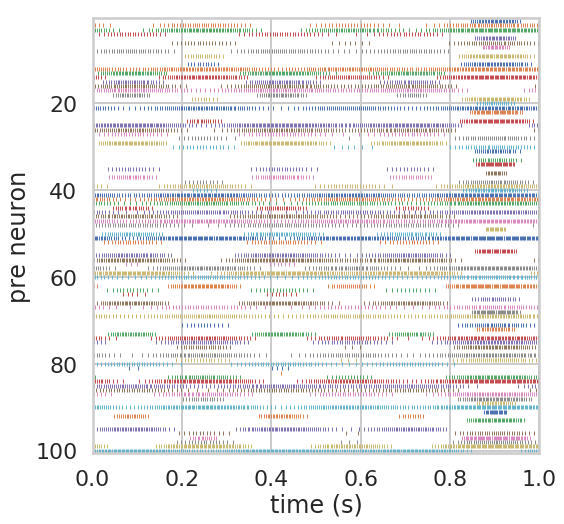

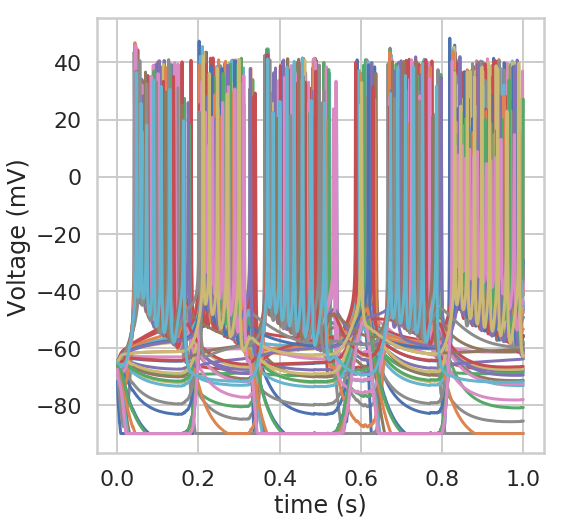

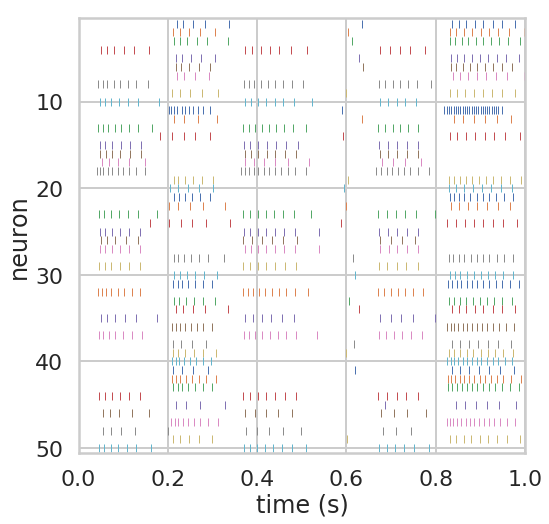

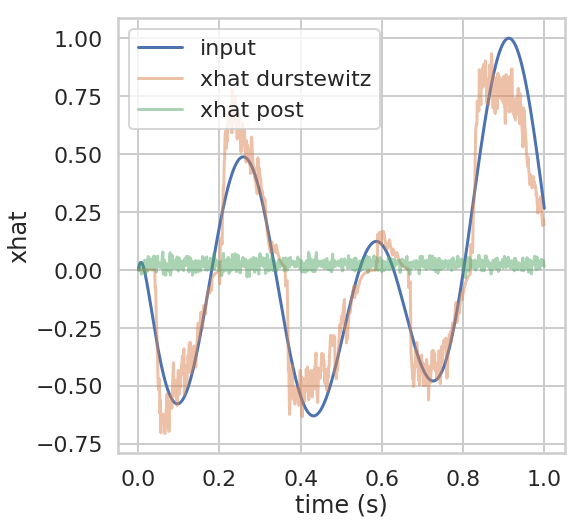

WARNING    /home/pduggins/nengo/nengo/builder/ensemble.py:97: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f81e2b73208> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens))
 [py.warnings]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

WARNING    /home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'brianens' on '<Connection from <Ensemble (unlabeled) at 0x7f81e2b738d0> to <Ensemble (unlabeled) at 0x7f81e2b73208>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
 [py.warnings]
WARNING    /home/pduggins/nengo/nengo/base.py:107: SyntaxWarning: Creating new attribute 'brianweights' on '<Connection from <Ensemble (unlabeled) at 0x7f81e2b738d0> to <Ensemble (unlabeled) at 0x7f81e2b73208>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
 [py.warnings]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

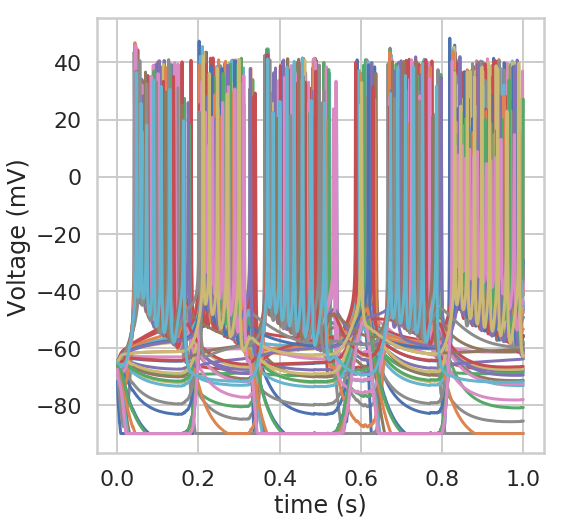

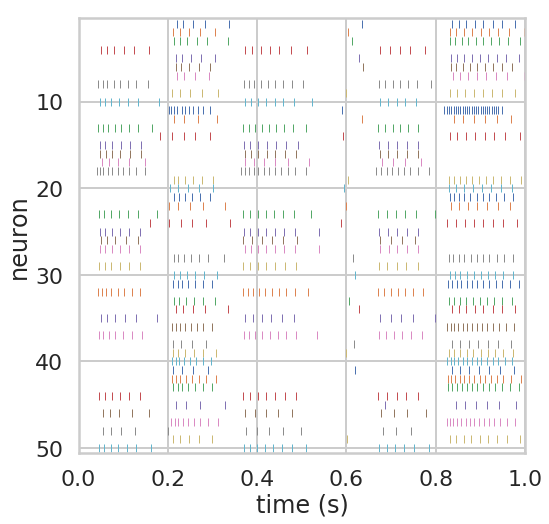

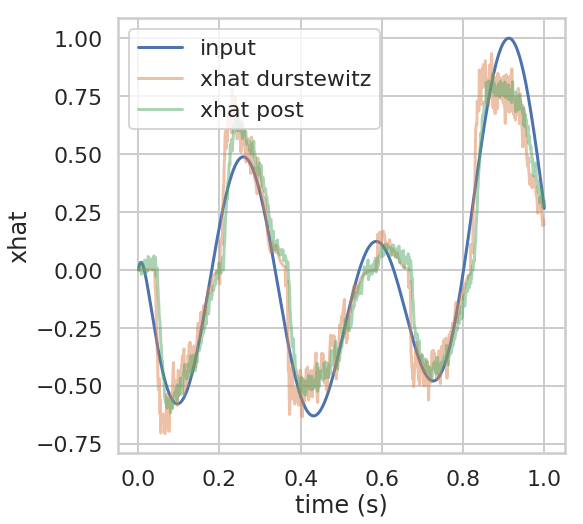

In [5]:
t0, tar0, pres0, s0, v0, post0 = go(n_neurons, t=t, dt=dt, d=d,
    gain=gain, bias=bias, max_rates=max_rates, intercepts=intercepts,
    neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t0, pres0)
ax.set(xlabel='time (s)', ylabel='pre neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t0, v0/mV)
ax.set(xlabel='time (s)', ylabel='Voltage (mV)')
plt.show()

a0 = nengo.Lowpass(tau).filt(s0)
d = LstsqL2(reg=reg)(a0, tar0)[0]
xhat0 = np.dot(a0, d)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t0, s0)
ax.set(xlabel='time (s)', ylabel='neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t0, tar0, label='input')
ax.plot(t0, xhat0, label='xhat durstewitz', alpha=0.5)
ax.plot(t0, post0, label='xhat post', alpha=0.5)
ax.legend()
ax.set(xlabel='time (s)', ylabel='xhat')
plt.show()

t1, tar1, pres1, s1, v1, post1 = go(n_neurons, t=t, dt=dt, d=d,
    gain=gain, bias=bias, max_rates=max_rates, intercepts=intercepts,
    neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

a1 = nengo.Lowpass(tau).filt(s1)
xhat1 = np.dot(a1, d)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t1, v1/mV)
ax.set(xlabel='time (s)', ylabel='Voltage (mV)')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t1, s1)
ax.set(xlabel='time (s)', ylabel='neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t1, tar1, label='input')
ax.plot(t1, xhat1, label='xhat durstewitz', alpha=0.5)
ax.plot(t1, post1, label='xhat post', alpha=0.5)
ax.legend()
ax.set(xlabel='time (s)', ylabel='xhat')
plt.show()